# 教程二：迁移学习 - 从MNIST到USPS

In [ ]:
# MNIST是一个数字手写体的小数据集，经常用来演示如何训练简单的卷积神经网络

# 我们先来导入必须要用到的库

In [1]:
import torch

In [2]:
from torchvision.datasets import MNIST

In [3]:
from torchvision import transforms

In [4]:
# 定义一些转换，如归一化
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (1.0, ))])

In [5]:
# 加载训练数据集
train_set = MNIST(root='./data', train=True, transform=transf, download=False)

In [6]:
# 查看数据集大小
train_set.train_data.shape

torch.Size([60000, 28, 28])

In [7]:
train_set.train_data[0];

In [8]:
# 用matplotlib做可视化
%matplotlib inline
import matplotlib.pyplot as plt

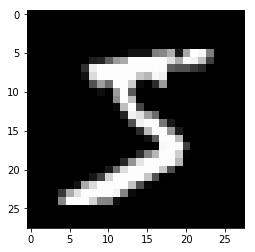

In [9]:
train_set.train_data[0].shape
plt.imshow(train_set.train_data[0], cmap='gray')

In [10]:
train_set.train_labels[0]

tensor(5)

In [11]:
# 加载测试数据集
test_set = MNIST(root='./data', train=False, transform=transf, download=False)

In [16]:
# 显示混淆矩阵，来看模型对不同的标签的推测准确度
# 一个100%正确的模型将会显示一条对角白线
def confusion(model, n, dataset):
    conf = torch.zeros(n, n)
    model.eval() # 把模型设置到推理模式
    for data, target in dataset:
        data = data.unsqueeze(1)
        output = model(data)
        _, pred = torch.max(output.data, 1)
        conf[target][pred[0]] += 1
        
    # 归一化
    for i in range(n):
        conf[i] = conf[i] / conf[i].sum()
        
    plt.matshow(conf.numpy(), cmap='gray')
    plt.show()

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
# 定义卷积神经网络
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 20 * 4 * 4) # -1的意思是我们只关注最后一个维度的大小，然后把剩下的维度都合并成一个维度
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [19]:
from torch import optim

In [21]:
from torch.utils.data import DataLoader

In [22]:
def plot_loss_curve(nepochs, test_losses, accuracies):
    plt.title('MNIST loss curve')
    plt.xticks(np.arange(0, nepochs, 1))
    plt.plot(range(nepochs), test_losses, 'r--', label='Loss')
    plt.plot(range(nepochs), accuracies, 'b', label='Accuracy')
    plt.legend()

In [23]:
def train_model(model, train_set, test_set, nepochs):
    batch_size = 500
    # dataloader的作用是帮助得到批量化的训练样本，以及把样本的顺序打乱
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set)
    
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.5)
    
    model.train()
    
    accuracies = []
    test_losses = []
    
    for epoch in range(nepochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad() # 清空这个模型在之前保存下来的梯度
            output = model(data) # 这个的输出是log softmax
            loss = F.nll_loss(output, target) # 负对数似然函数
            loss.backward()
            optimizer.step()
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), float(loss)), end='\r')

        model.eval()
        test_loss = 0.0
        correct = 0
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).data.item()
            
            _, pred = torch.max(output.data, 1)
            
            correct += (pred == target.data).sum()
            
        test_loss /= len(test_set)
        test_losses.append(test_loss)
        accuracy = float(correct)/len(test_set)
        accuracies.append(accuracy)
        print("\nLoss: {:.6f} Accuracy: {:.3f}%".format(test_loss, 100.0 * accuracy))

    plot_loss_curve(nepochs, test_losses, accuracies)

In [24]:
model = CNN()

Train Epoch: 0 [59500/60000 (99%)]	Loss: 1.909954
Loss: 1.870433 Accuracy: 59.330%
Train Epoch: 1 [59500/60000 (99%)]	Loss: 0.359892
Loss: 0.314460 Accuracy: 90.740%
Train Epoch: 2 [59500/60000 (99%)]	Loss: 0.304518
Loss: 0.226217 Accuracy: 93.180%
Train Epoch: 3 [59500/60000 (99%)]	Loss: 0.182854
Loss: 0.161939 Accuracy: 95.270%
Train Epoch: 4 [59500/60000 (99%)]	Loss: 0.137062
Loss: 0.127354 Accuracy: 96.300%
Train Epoch: 5 [59500/60000 (99%)]	Loss: 0.133403
Loss: 0.117618 Accuracy: 96.570%
Train Epoch: 6 [59500/60000 (99%)]	Loss: 0.195417
Loss: 0.104229 Accuracy: 96.800%
Train Epoch: 7 [59500/60000 (99%)]	Loss: 0.097892
Loss: 0.096282 Accuracy: 96.980%
Train Epoch: 8 [59500/60000 (99%)]	Loss: 0.095860
Loss: 0.082775 Accuracy: 97.470%
Train Epoch: 9 [59500/60000 (99%)]	Loss: 0.074427
Loss: 0.074009 Accuracy: 97.710%


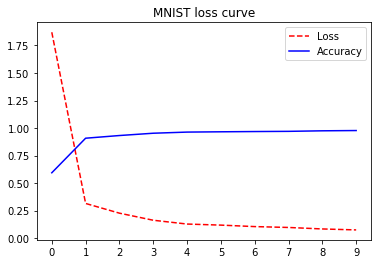

In [25]:
train_model(model, train_set, test_set, 10)

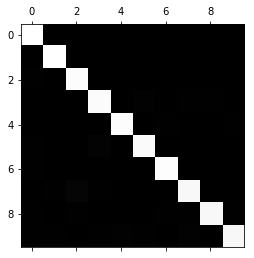

In [26]:
confusion(model, 10, test_set) # 显示混淆矩阵

In [27]:
# 把训练好的模型保存下来
torch.save(model.state_dict(), 'mnist.pth')